## ACCESS Model - CMIP Monthly Average

This script loads monthly climate model data from the CMIP6 ACCESS-ESM1-5 `cmip` experiment, specifically the ensemble runs provided under:

```
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical

```

#### Purpose
The goal is to construct a single `xarray.Dataset` that combines a selected set of atmospheric variables across all available ensemble members. This will facilitate ensemble-based climate analysis (e.g., mean, spread).

#### Process
- The script targets 5 monthly atmospheric variables: `pr`, `uas`, `vas`, `ps`, `tas`.
- Each ensemble member is stored in its own subdirectory (one per run), and each variable is located under the `Amon` realm in NetCDF format.
- A helper function loads the requested variables for each run using `open_mfdataset` (lazy loading, parallel enabled).
- A special case is handled for `tas`: if the dataset contains a spurious `'height'` coordinate, it is dropped to avoid merge conflicts.
- Each merged run dataset is tagged with a new dimension `run` using the run name (e.g., `r1i1p1f1`) and added to a list.
- Finally, all run datasets are concatenated along the `run` dimension to produce the ensemble dataset `ensemble_ds`.


In [1]:
# For run 'r10i1p1f1': time slice 2010/03 - 2011/02
# For run 'r1i1p1f1': time slice 2006/03 - 2007/02

In [2]:
import xarray as xr
import os
from glob import glob
import pathlib

# Define base path
access_cmip_path = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical'
variables = ['pr', 'uas', 'vas', 'ps', 'tas']
file_pattern = '*Amon_ACCESS-ESM1-5_historical*gn_185001-201412.nc'

# Define runs and their specific time slices
runs_with_periods = {
    'r10i1p1f1': ("2010-03", "2011-02"),
    'r1i1p1f1':  ("2006-03", "2007-02")
}

# Container for ensemble datasets
ensemble_datasets = []

def load_variable_for_run(run, variable, time_slice, reference_grid=None):
    """Load a variable for a specific run. Interpolate to reference_grid if provided."""
    path = os.path.join(access_cmip_path, run, 'Amon', variable, 'gn', 'latest')
    files = glob(os.path.join(path, file_pattern))
    if not files:
        raise FileNotFoundError(f"No file found for {run}/{variable}")

    # Open the dataset
    ds = xr.open_dataset(files[0])
    
    # Crop to the desired time slice
    ds = ds.sel(time=slice(*time_slice))

    # Drop height if present
    if 'height' in ds.coords:
        ds = ds.drop_vars('height')
    
    # Interpolate if needed
    if reference_grid is not None:
        ds = ds.interp(lat=reference_grid.lat, lon=reference_grid.lon)
    
    return ds

# Loop over specified runs
for run, time_slice in runs_with_periods.items():
    try:
        print(f"Processing run: {run}, time slice: {time_slice}")

        # Load 'pr' first to define the grid
        pr_ds = load_variable_for_run(run, 'pr', time_slice)
        reference_grid = pr_ds[['lat', 'lon']]

        # Load and align other variables
        uas_ds = load_variable_for_run(run, 'uas', time_slice, reference_grid)
        vas_ds = load_variable_for_run(run, 'vas', time_slice, reference_grid)
        ps_ds  = load_variable_for_run(run, 'ps', time_slice)
        tas_ds = load_variable_for_run(run, 'tas', time_slice)

        # Merge all
        ensemble_ds = xr.merge([pr_ds, uas_ds, vas_ds, ps_ds, tas_ds])
        ensemble_ds = ensemble_ds.expand_dims({'run': [run]})
        
        ensemble_datasets.append(ensemble_ds)

    except Exception as e:
        print(f"Skipping run {run} due to error: {e}")

# Concatenate into one dataset
ensemble_ds = xr.concat(ensemble_datasets, dim='run')

# Inspect result
print(ensemble_ds)


Processing run: r10i1p1f1, time slice: ('2010-03', '2011-02')
Processing run: r1i1p1f1, time slice: ('2006-03', '2007-02')
<xarray.Dataset> Size: 37MB
Dimensions:    (run: 2, time: 24, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 192B 2006-03-16T12:00:00 ... 2011-02-15
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * run        (run) object 16B 'r10i1p1f1' 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] 768B NaT NaT NaT ... NaT NaT NaT
    lat_bnds   (run, lat, bnds) float64 5kB -90.0 -89.38 -89.38 ... 89.38 90.0
    lon_bnds   (run, lon, bnds) float64 6kB -0.9375 0.9375 ... 357.2 359.1
    pr         (run, time, lat, lon) float32 5MB nan nan nan nan ... nan nan nan
    uas        (run, time, lat, lon) float64 11MB nan nan nan ... nan nan nan
    vas        (run, time, lat, lon) fl

### Cleaning Unwanted Coordinates and Auxiliary Variables

After merging all ensemble members into a single dataset (`ensemble_ds`), this step removes auxiliary variables and coordinates that are not needed for analysis.

#### Purpose
Some NetCDF files include additional metadata or bounds variables (e.g., `height`, `*_bnds`) that:
- Are not used in typical climate analyses,
- May interfere with downstream processing or file size,
- Can create issues during plotting or NetCDF export.

#### Process
The following variables are removed **if present**:
- `height`: a single-value coordinate sometimes added to variables like `tas`.
- `time_bnds`, `lat_bnds`, `lon_bnds`: auxiliary bounds commonly included in CMIP outputs.

The script checks for each in both data variables and coordinates, and drops them safely.

This results in a cleaner, more manageable dataset ready for analysis or saving.


In [3]:
# Drop undesired coordinate and auxiliary variables
cleanup_vars = ['time_bnds', 'lat_bnds', 'lon_bnds']
for var in cleanup_vars:
    if var in ensemble_ds:
        ensemble_ds = ensemble_ds.drop_vars(var)
    elif var in ensemble_ds.coords:
        ensemble_ds = ensemble_ds.drop_vars(var)  # works for coords too

# Confirm clean dataset
print("Cleaned ensemble dataset:")
ensemble_ds


Cleaned ensemble dataset:


<xarray.Dataset> Size: 37MB
Dimensions:  (run: 2, time: 24, lat: 145, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 192B 2006-03-16T12:00:00 ... 2011-02-15
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * run      (run) object 16B 'r10i1p1f1' 'r1i1p1f1'
Data variables:
    pr       (run, time, lat, lon) float32 5MB nan nan nan nan ... nan nan nan
    uas      (run, time, lat, lon) float64 11MB nan nan nan nan ... nan nan nan
    vas      (run, time, lat, lon) float64 11MB nan nan nan nan ... nan nan nan
    ps       (run, time, lat, lon) float32 5MB nan nan nan nan ... nan nan nan
    tas      (run, time, lat, lon) float32 5MB nan nan nan nan ... nan nan nan
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  87658.0
    creation_date:          2020-06-05T04:06:11Z
    ...                     ...
    variable_id:            pr
    variant_label:          r10i1p1f1
    version:                v20200605
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/88e21490-91ee-471c-9839-15b0e5a844e4

### Customary CMIP Monthly Average Timestamps
I did not know that, but it makes sense that monthly averaged timestamp be placed around the middle of a given month.

In [4]:
# Convert time coordinate to numpy datetime array for inspection
time_values = ensemble_ds.time.values
print(time_values)


['2006-03-16T12:00:00.000000000' '2006-04-16T00:00:00.000000000'
 '2006-05-16T12:00:00.000000000' '2006-06-16T00:00:00.000000000'
 '2006-07-16T12:00:00.000000000' '2006-08-16T12:00:00.000000000'
 '2006-09-16T00:00:00.000000000' '2006-10-16T12:00:00.000000000'
 '2006-11-16T00:00:00.000000000' '2006-12-16T12:00:00.000000000'
 '2007-01-16T12:00:00.000000000' '2007-02-15T00:00:00.000000000'
 '2010-03-16T12:00:00.000000000' '2010-04-16T00:00:00.000000000'
 '2010-05-16T12:00:00.000000000' '2010-06-16T00:00:00.000000000'
 '2010-07-16T12:00:00.000000000' '2010-08-16T12:00:00.000000000'
 '2010-09-16T00:00:00.000000000' '2010-10-16T12:00:00.000000000'
 '2010-11-16T00:00:00.000000000' '2010-12-16T12:00:00.000000000'
 '2011-01-16T12:00:00.000000000' '2011-02-15T00:00:00.000000000']


### Compute Seasonal and Total Averages

This step calculates the climatological means across time for the full ensemble dataset:

- **Total Average**: Mean over all time steps.
- **JJA**: June–August average (austral winter).
- **DJF**: December–February average (spanning years).
- **MAM**: March–May average (austral autumn).
- **SON**: September–November average (austral spring).

Each average is computed by selecting the relevant months and taking the mean along the `time` dimension.


In [5]:
# Function to copy attributes
def copy_attributes(original_ds, new_ds):
    """Copy attributes from original_ds to new_ds"""
    for var in original_ds.data_vars:
        if var in new_ds:
            new_ds[var].attrs.update(original_ds[var].attrs)
    return new_ds

# Total Time Average
total_avg = ensemble_ds.mean(dim='time')
total_avg = copy_attributes(ensemble_ds, total_avg)

# JJA (June, July, August) Average
jja_avg = ensemble_ds.sel(time=ensemble_ds['time.month'].isin([6, 7, 8])).mean(dim='time')
jja_avg = copy_attributes(ensemble_ds, jja_avg)

# DJF (December, January, February) Average
djf_avg = ensemble_ds.sel(time=ensemble_ds['time.month'].isin([12, 1, 2])).mean(dim='time')
djf_avg = copy_attributes(ensemble_ds, djf_avg)

# MAM (March, April, May) Average
mam_avg = ensemble_ds.sel(time=ensemble_ds['time.month'].isin([3, 4, 5])).mean(dim='time')
mam_avg = copy_attributes(ensemble_ds, mam_avg)

# SON (September, October, November) Average
son_avg = ensemble_ds.sel(time=ensemble_ds['time.month'].isin([9, 10, 11])).mean(dim='time')
son_avg = copy_attributes(ensemble_ds, son_avg)


### Estimate Memory Size of DJF Average

This block calculates the in-memory size of the `djf_avg` dataset in megabytes. While this provides a sense of the dataset's footprint during processing, note that saving the dataset with compression (e.g., NetCDF with `zlib=True`) will significantly reduce disk space usage.


In [6]:
# Calculate the size of djf_avg in bytes
djf_avg_size_bytes = djf_avg.nbytes

# Convert bytes to megabytes
djf_avg_size_mb = djf_avg_size_bytes / 1024 / 1024

# Print the result
print(f"Size of djf_avg: {djf_avg_size_mb:.2f} MB")


Size of djf_avg: 1.49 MB


### Save Averages to NetCDF Files

This step saves the computed seasonal and total averages to NetCDF files. The output is saved in the specified directory with filenames indicating the type of average (e.g., `tot`, `jja`, `djf`) and the corresponding period.

Compression is applied to reduce file size (`zlib=True`, `complevel=2`), ensuring efficient storage.

Files are saved with the following naming convention:
- `access_cmip_ensemble_tot_avg_201303_201402.nc`
- `access_cmip_ensemble_jja_avg_201303_201402.nc`
- `access_cmip_ensemble_djf_avg_201303_201402.nc`
- `access_cmip_ensemble_mam_avg_201303_201402.nc`
- `access_cmip_ensemble_son_avg_201303_201402.nc`


In [7]:
# Output directory
record_path = '/scratch/nf33/hk25-ConvZones'

# Compression settings — assuming all averages have the same variables
encoding = {var: {'zlib': True, 'complevel': 2} for var in total_avg.data_vars}

# Save Total Average
total_avg.to_netcdf(
    f'{record_path}/access_cmip_ensemble_tot_avg.nc',
    encoding=encoding
)

# Save JJA Average
jja_avg.to_netcdf(
    f'{record_path}/access_cmip_ensemble_jja_avg.nc',
    encoding=encoding
)

# Save DJF Average
djf_avg.to_netcdf(
    f'{record_path}/access_cmip_ensemble_djf_avg.nc',
    encoding=encoding
)

# Save MAM Average
mam_avg.to_netcdf(
    f'{record_path}/access_cmip_ensemble_mam_avg.nc',
    encoding=encoding
)

# Save SON Average
son_avg.to_netcdf(
    f'{record_path}/access_cmip_ensemble_son_avg.nc',
    encoding=encoding
)


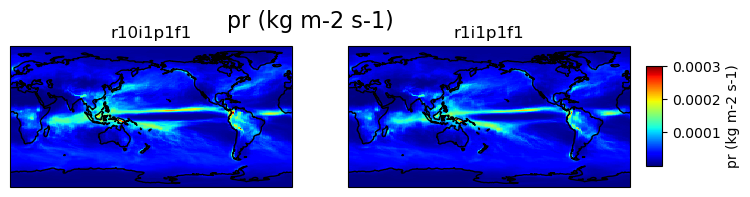

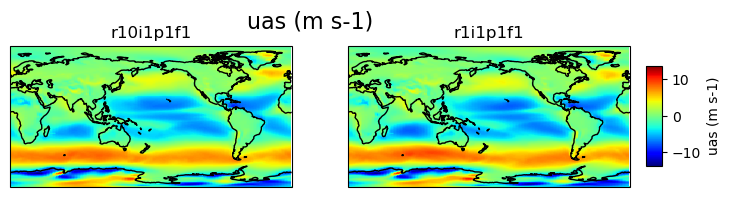

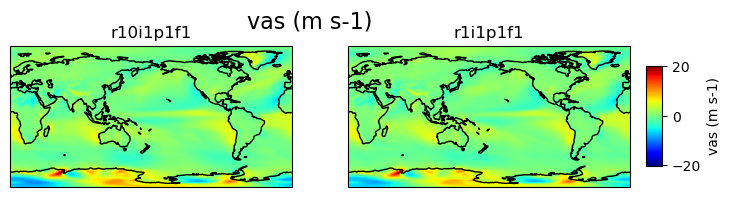

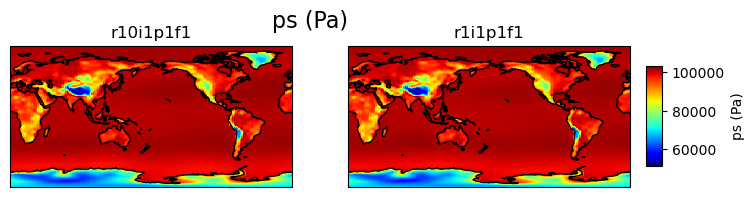

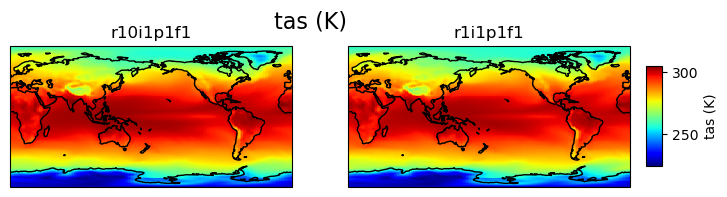

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

# Load dataset
file_path = f'/scratch/nf33/hk25-ConvZones/access_cmip_ensemble_tot_avg.nc'
ds = xr.open_dataset(file_path)

# Loop through variables
for var in ds.data_vars:
    data = ds[var]
    runs = data.run.values
    n_runs = len(runs)
    
    # Determine subplot layout (2 rows)
    ncols = n_runs
    nrows = 1

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(4 * ncols, 2 * nrows),
        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
    )
    axes = axes.flatten()  # for easy indexing

    for i, run in enumerate(runs):
        ax = axes[i]
        run_data = data.sel(run=run)

        # Plot the data
        im = run_data.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            x='lon', y='lat',
            add_colorbar=False,
            cmap='jet'
        )

        ax.coastlines()
        ax.set_title(f'{run}')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
    
    # Retrieve units from the variable's attributes
    units = ds[var].attrs.get('units')
    
    # Add colorbar with units
    fig.colorbar(im, cax=cbar_ax, label=f"{var} ({units})")

    fig.suptitle(f"{var} ({units})", fontsize=16, y=1.03)
    plt.show()


In [9]:
# Print units for each variable in the dataset
for var in ensemble_ds.data_vars:
    if 'units' in ensemble_ds[var].attrs:
        print(f"Variable: {var}, Units: {ensemble_ds[var].attrs['units']}")
    else:
        print(f"Variable: {var} does not have units attribute.")


Variable: pr, Units: kg m-2 s-1
Variable: uas, Units: m s-1
Variable: vas, Units: m s-1
Variable: ps, Units: Pa
Variable: tas, Units: K
